<a href="https://colab.research.google.com/github/iamnotpi/PyTorch-models/blob/main/tinyGoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision.transforms import v2
import torchvision.transforms
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import matplotlib.pyplot as plt

from accelerate import Accelerator, notebook_launcher
from accelerate.utils import set_seed

In [ ]:
torch.cuda.device_count()

2

In [ ]:
!nvidia-smi

Sun Mar 31 08:46:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
CIFAR10_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
CIFAR10_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

In [ ]:
def cifar_train_dataloader(val_split=0.2, batch_size=32, num_workers=2, shuffle=True):
    # Transformations pipeline
    # For transformation illustrations, see: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
    train_transform = v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomRotation(degrees=(0, 20)),
        v2.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD)
    ])
    train_data = datasets.CIFAR10('./data',
                                   train=True, # train version or not
                                   download=True,
                                   transform=train_transform,
                                   target_transform=None)
    train_set, val_set = random_split(train_data, [1 - val_split, val_split])
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers= num_workers, shuffle=shuffle)
    val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return train_loader, val_loader


In [ ]:
def cifar_test_dataloader(batch_size=32, shuffle=False):
    test_transform = v2.Compose([
        v2.ToTensor(),
        v2.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD)
    ])
    test_data = datasets.CIFAR10('./data',
                                  train=False,
                                  download=True,
                                  transform=test_transform,
                                  target_transform=None)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)
    return test_loader

In [ ]:
class Conv2dWithActivation(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU(), **kwargs):
        super().__init__()
        self.activation = activation
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

class InceptionModule(nn.Module):
    """ Inception module as described in the paper "Going Deeper with Convolutions" by Szegedy et al.
    The parameters' names are referenced from the paper.

    Args:
        in_channels: Number of input channels
        out_channels_1: Number of output channels for the 1x1 conv layer
        reduce_3x3: Number of output channels for the 1x1 conv layer before the 3x3 conv layer
        out_channels_3: Number of output channels for the 3x3 conv layer
        reduce_5x5: Number of output channels for the 1x1 conv layer before the 5x5 conv layer
        out_channels_5: Number of output channels for the 5x5 conv layer
        pool_proj: Number of output channels for the 1x1 conv layer before the pooling layer
    """
    def __init__(self, in_channels, out_channels_1, reduce_3x3, out_channels_3, reduce_5x5, out_channels_5, pool_proj):
        super().__init__()
        self.conv_1 = Conv2dWithActivation(in_channels, out_channels_1, 1)
        self.reduce_3x3 = Conv2dWithActivation(in_channels, reduce_3x3, 1)
        self.reduce_5x5 = Conv2dWithActivation(in_channels, reduce_5x5, 1)
        self.conv_3 = Conv2dWithActivation(reduce_3x3, out_channels_3, 3, padding=1)
        self.conv_5 = Conv2dWithActivation(reduce_5x5, out_channels_5, 5, padding=2)
        self.pool_proj = Conv2dWithActivation(in_channels, pool_proj, 1)
        self.max_pool = nn.MaxPool2d(3, stride=1, padding=1)

    def forward(self, x):
        return torch.cat((
                self.conv_1(x),
                self.conv_3(self.reduce_3x3(x)),
                self.conv_5(self.reduce_5x5(x)),
                self.pool_proj(self.max_pool(x))
            ), dim=1 # Tensors of shape (batch_size, num_filters, height, width) so dim=1
        )

class GoogLeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.main_layer = nn.Sequential(
            Conv2dWithActivation(3, 64, 7, padding=3, stride=2),
            nn.MaxPool2d(3, 2, padding=1),
            Conv2dWithActivation(64, 192, 3, padding=1),
            nn.MaxPool2d(3, 2, padding=1),
            InceptionModule(192, 64, 96, 128, 16, 32, 32),
            InceptionModule(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, padding=1),
            InceptionModule(480, 192, 96, 208, 16, 48, 64),
            InceptionModule(512, 160, 112, 224, 24, 64, 64),
            InceptionModule(512, 128, 128, 256, 24, 64, 64),
            InceptionModule(512, 112, 144, 288, 32, 64, 64),
            InceptionModule(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2, padding=1),
            InceptionModule(832, 256, 160, 320, 32, 128, 128),
            InceptionModule(832, 384, 192, 384, 48, 128, 128),
            nn.AvgPool2d(7),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        return self.main_layer(x)

In [ ]:
class tinyGoogLeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.main_layer = nn.Sequential(
            nn.BatchNorm2d(3),
            Conv2dWithActivation(3, 64, 7, padding=3, stride=2),
            nn.MaxPool2d(3, 2, padding=1),
            Conv2dWithActivation(64, 128, 3, padding=1),
            nn.MaxPool2d(3, 2, padding=1),
            InceptionModule(128, 64, 96, 128, 16, 32, 32),
            nn.Dropout(0.3),
            InceptionModule(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, padding=1),
            InceptionModule(480, 192, 96, 208, 16, 48, 64),
            InceptionModule(512, 112, 144, 288, 32, 64, 64),
            nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(528, num_classes),
        )

    def forward(self, x):
        return self.main_layer(x)

In [ ]:
def accuracy(y_preds, y_test):
    correct =  torch.eq(y_preds, y_test).sum().item()
    return correct / len(y_preds) * 100

In [ ]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.show()

In [ ]:
epochs = 25

def train(seed=42, batch_size=128):
    train_loss_array, val_loss_array = [], []
    set_seed(seed)
    # Initialize accelerator
    accelerator = Accelerator()

    model = tinyGoogLeNet(10)
    optimizer = torch.optim.Adam(params=model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    train_dataloader, val_dataloader = cifar_train_dataloader(batch_size=batch_size)
    model, train_dataloader, val_dataloader, optimizer = accelerator.prepare(
        model, train_dataloader, val_dataloader, optimizer
    )

    for epoch in range(epochs):
        model.train()
        loss, acc = 0.0, 0.0

        for X_train, y_train in train_dataloader:
            # X_train, y_train = X_train.to(device), y_train.to(device)
            y_logits = model(X_train).squeeze()
            batch_loss = loss_fn(y_logits, y_train)
            optimizer.zero_grad()
            accelerator.backward(batch_loss)
            optimizer.step()
            loss += batch_loss.item()
            acc += accuracy(y_logits.argmax(dim=-1), y_train)
        loss /= len(train_dataloader)
        acc /= len(train_dataloader)
        accelerator.print(f"Epoch: {epoch + 1} | Training loss: {loss:.4f} | Training acc: {acc:.2f}% ", end="")
        train_loss_array.append(loss)

        with torch.inference_mode():
            model.eval()
            val_loss, val_acc = 0.0, 0.0
            for X_val, y_val in val_dataloader:
                # X_val, y_val = X_val.to(device), y_val.to(device)
                y_val_logits = model(X_val).squeeze()
                val_loss += loss_fn(y_val_logits, y_val).item()
                val_acc += accuracy(y_val_logits.argmax(dim=-1), y_val)
            val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)
            accelerator.print(f"| Validation loss: {val_loss:.4f} | Validation acc: {val_acc:.2f}%")
        val_loss_array.append(val_loss)

    plot_loss(train_loss_array, val_loss_array)

    accelerator.wait_for_everyone()

    # Unwrap the model from any distributed wrapping that was performed
    model = accelerator.unwrap_model(model)

    # Save the model once
    accelerator.save(model, "model.pth")

Launching training on 2 GPUs.


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 | Training loss: 1.9462 | Training acc: 23.31% | Validation loss: 1.7212 | Validation acc: 33.42%
Epoch: 2 | Training loss: 1.5978 | Training acc: 38.55% | Validation loss: 1.4873 | Validation acc: 44.79%
Epoch: 3 | Training loss: 1.4071 | Training acc: 47.48% | Validation loss: 1.3660 | Validation acc: 50.27%
Epoch: 4 | Training loss: 1.2843 | Training acc: 52.88% | Validation loss: 1.2292 | Validation acc: 55.62%
Epoch: 5 | Training loss: 1.2040 | Training acc: 57.28% | Validation loss: 1.1518 | Validation acc: 57.93%
Epoch: 6 | Training loss: 1.1345 | Training acc: 59.52% | Validation loss: 1.0954 | Validation acc: 60.35%
Epoch: 7 | Training loss: 1.0623 | Training acc: 62.42% | Validation loss: 1.0508 | Validation acc: 62.79%
Epoch: 8 | Training loss: 1.0016 | Training acc: 64.72% | Validation loss: 1.0543 | Validation acc: 62.27%
Epoch: 9 | Training loss: 0.9869 | Training acc: 64.95% | Validation

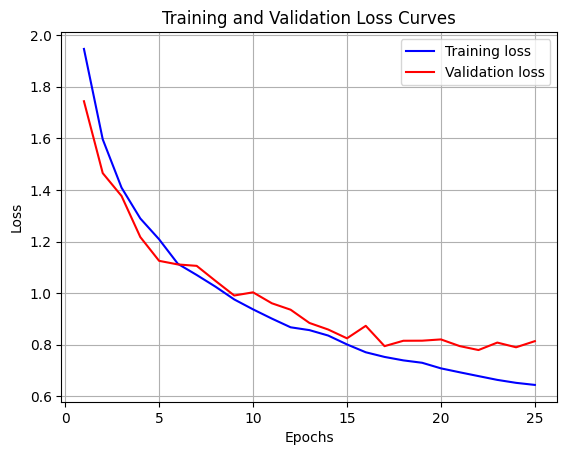

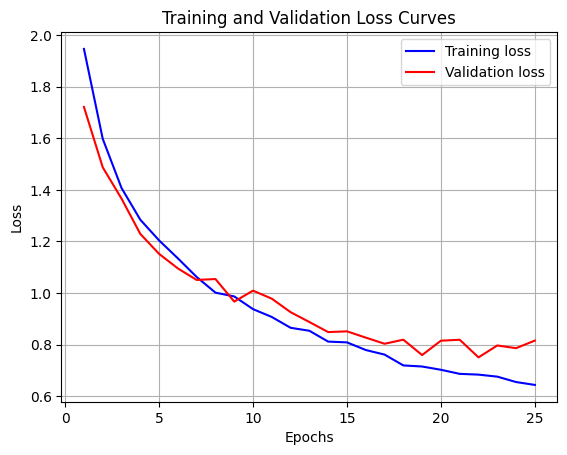

In [ ]:
args = (42, 128)
notebook_launcher(train, args, num_processes=2)

In [ ]:
model = torch.load("model.pth")
model.eval()

test_dataloader = cifar_test_dataloader()
test_acc = 0.0

device = "cuda" if torch.cuda.is_available() else "cpu"
with torch.inference_mode():
    for X_test, y_test in test_dataloader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_preds = model(X_test).squeeze()
        test_acc += accuracy(y_preds.argmax(dim=1), y_test)
    test_acc /= len(test_dataloader)

print(f"Test accuracy: {test_acc:.2f}%")

Files already downloaded and verified
Test accuracy: 72.73%
